In [1]:
import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt
from escnn import group, gspaces

import sys

sys.path.append("..")

from models.core.point_convolution import ImplicitPointConv

# G-steerable Point Convolution

Similarly to a grid convolution, we can define a point convolution layer. We will use the similar setup here:
- symmetry: O(2) or SO(2) on $\mathbb{R}^2$.
- data: scalar and vector fields
    - scalar: $sin(x) + cos(y)$",
    - vector: $\left[sin(x) sin(y), cos(x) + cos(y)^2\right]$",

In [2]:
g = "so2"

In [3]:
if g == "o2":
    gspace = gspaces.flipRot2dOnR2()
elif g == "so2":
    gspace = gspaces.rot2dOnR2()

In [4]:
scalar_repr = gspace.trivial_repr
vector_repr = gspace.fibergroup.standard_representation()

channel_repr = group.directsum([scalar_repr, vector_repr])

In [5]:
c_in = 1
c_out = 12

in_repr = c_in * [channel_repr]
out_repr = c_out * [channel_repr]

in_type = gspace.type(*in_repr)
out_type = gspace.type(*out_repr)

The only difference is that the kernels now can be conditioned on local features as well (e.g. edge features), since we recompute kernels at for each connection anyways. 
Let's assume that we want to condition kernels on edge attributes, e.g. distances. Distances are scalars, and hence transform according to the trivial representation.

In [6]:
c_attr = 7
attr_repr = c_attr * [gspace.trivial_repr]
kernel_attr_type = gspace.type(*attr_repr)

In [7]:
conv = ImplicitPointConv(
    in_type=in_type,
    out_type=out_type,
    edge_attr_type=kernel_attr_type,
    n_layers=2,
    n_channels=12,
    init_scheme="he",
)

Let us now sample a random point cloud and compute the value of the field at each point.

In [8]:
n_points = 1000

x, y = 2 * torch.pi * torch.rand(n_points), 2 * torch.pi * torch.rand(n_points)

scalar = torch.sin(x) + torch.cos(y)
vector_x = torch.sin(x) * torch.sin(y)
vector_y = torch.cos(x) + torch.cos(y) ** 2

field = torch.stack([scalar, vector_x, vector_y], dim=-1)

Now we visualize it to make sure everything is correct. The result should look similar to the plot in the previous exampl (up to axis orientation).

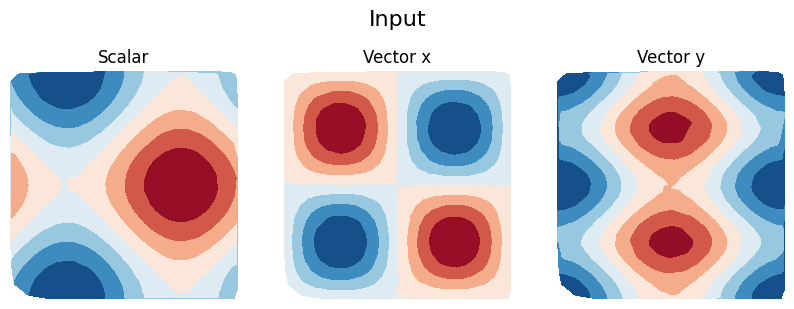

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y"]

for i in range(3):
    ax[i].tricontourf(x.numpy(), y.numpy(), field[:, i].numpy(), cmap="RdBu")
    ax[i].axis("off")
    ax[i].set_title(component_names[i])
    ax[i].set_aspect("equal", adjustable="box")

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(0.5, 1.2, "Input", ha="center", fontsize=16, transform=ax[1].transAxes)
plt.show()

Let us now wrap it up as data on a graph. For that we need:
- node features;
- node positions;
- connectivity information (edge_index);
- edge attributes;

In [10]:
pos = torch.stack([x, y], dim=-1)
edge_index = torch_geometric.nn.pool.knn_graph(pos, k=32, batch=None, loop=True)
edge_attr = torch.randn(edge_index.size(1), c_attr * gspace.trivial_repr.size)
edge_delta = pos[edge_index[0]] - pos[edge_index[1]]

Everything is set up, we can now apply the convolution to the input field. Let's embed our data in a geometric tensor and apply the convolution.

In [11]:
field_gt = in_type(field, pos)

In [12]:
out = conv(field_gt, edge_index, edge_delta, edge_attr).tensor.detach().numpy()

Let's visualize the output of the convolutional layer.

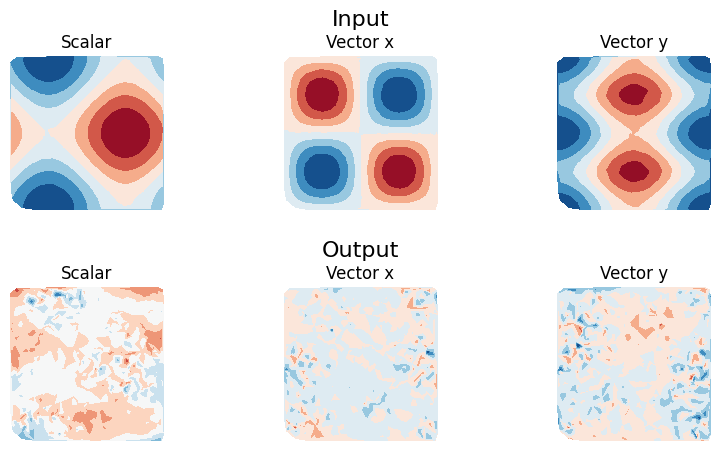

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y"]

for i in range(3):
    ax[0, i].tricontourf(x.numpy(), y.numpy(), field[:, i].numpy(), cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])
    ax[0, i].set_aspect("equal", adjustable="box")

for i in range(3):
    ax[1, i].tricontourf(x.numpy(), y.numpy(), out[:, i], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])
    ax[1, i].set_aspect("equal", adjustable="box")

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(0.5, 1.2, "Input", ha="center", fontsize=16, transform=ax[0, 1].transAxes)
plt.text(0.5, 1.2, "Output", ha="center", fontsize=16, transform=ax[1, 1].transAxes)
plt.show()

### Equivariance test

To make sure the convolution is indeed equivariant, we need to do the equivariance test. 
We will do this by comparing $T(\mathcal{C}(x))$ with $\mathcal{C}(T(x))$, where $T$ is the transformation and $C$ is convolution.

In [14]:
std_repr = gspace.fibergroup.standard_representation()
std_type = gspace.type(std_repr)

edge_attr_type = gspace.type(*attr_repr)

edge_delta = pos[edge_index[0]] - pos[edge_index[1]]
edge_delta_gt = std_type(edge_delta, edge_delta)

edge_attr_gt = edge_attr_type(edge_attr, edge_delta)

In [15]:
errors = []

for el in list(gspace.testing_elements)[::10]:
    out1 = (
        conv(
            x=field_gt,
            edge_delta=edge_delta_gt.tensor,
            edge_index=edge_index,
            edge_attr=edge_attr_gt.tensor,
        )
        .transform(el)
        .tensor.detach()
        .numpy()
    )

    out2 = (
        conv(
            x=field_gt.transform(el),
            edge_delta=edge_delta_gt.transform(el).tensor,
            edge_index=edge_index,
            edge_attr=edge_attr_gt.transform(el).tensor,
        )
        .tensor.detach()
        .numpy()
    )

    errs = np.abs(out1 - out2) / (np.abs(out1) + np.abs(out2) + 1e-5)
    errors.append(errs.mean())

print(f"Average absolute error for the layer: {np.mean(errors):.2e}")

Average absolute error for the layer: 5.16e-06


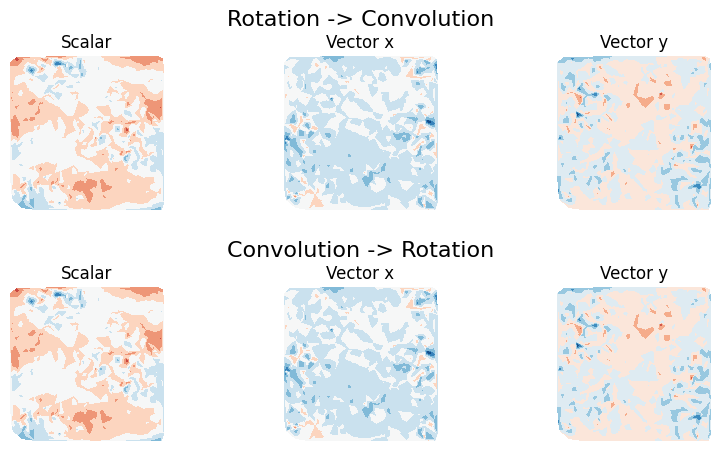

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y"]

for i in range(3):
    ax[0, i].tricontourf(x.numpy(), y.numpy(), out1[:, i], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])
    ax[0, i].set_aspect("equal", adjustable="box")

for i in range(3):
    ax[1, i].tricontourf(x.numpy(), y.numpy(), out2[:, i], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])
    ax[1, i].set_aspect("equal", adjustable="box")

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    0.5,
    1.2,
    "Rotation -> Convolution",
    ha="center",
    fontsize=16,
    transform=ax[0, 1].transAxes,
)
plt.text(
    0.5,
    1.2,
    "Convolution -> Rotation",
    ha="center",
    fontsize=16,
    transform=ax[1, 1].transAxes,
)
plt.show()